In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm import tqdm 

from torch.utils.data import DataLoader
import datasets


from resources.quantization_tools import *
from resources.wrapper import Wrapper
from resources.evaluation import eval
from resources.utils import prepare_dataset, print_file_size
from resources.finetuning import prepare_for_finetuning, ce_finetune, kd_finetune

device = 'cuda'

/home/msst/miniconda3/envs/quant_basics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'microsoft/resnet-18'
dataset_name = 'NotYourLady/BetterImageNet'

model_save_path = 'models'
cache_dir='dataset'

os.makedirs(model_save_path, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)

In [3]:
model = AutoModelForImageClassification.from_pretrained(model_name).to(device)
path_to_pretrained_resnet18 = os.path.join(model_save_path, 'pretrained_resnet-18')
model.save_pretrained(path_to_pretrained_resnet18)

In [4]:
dataset_prepared = True
if not dataset_prepared:
    prepare_dataset(dataset_name, model_name, cache_dir)

In [5]:
test_dataset = datasets.load_from_disk(os.path.join(cache_dir, 'test'))
train_dataset = datasets.load_from_disk(os.path.join(cache_dir, 'train'))

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

### FP32

In [21]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
print(eval(model, test_loader))
# {'top_1_accuracy': 0.6934, 'top_5_accuracy': 0.8882}

path_to_save = os.path.join(model_save_path, 'resnet_fp32.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)
# 44.678 Mb

Run evaluation...


100%|██████████| 40/40 [00:25<00:00,  1.56it/s]

{'top_1_accuracy': 0.6926, 'top_5_accuracy': 0.8878}
44.678 Mb


### FP16

In [22]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
model = model.half()
with torch.autocast(device_type='cuda'):
    print(eval(model, test_loader))
# {'top_1_accuracy': 0.6933, 'top_5_accuracy': 0.888}

path_to_save = os.path.join(path_to_pretrained_resnet18, 'resnet_fp16.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)
# 22.363 Mb

Run evaluation...


100%|██████████| 40/40 [00:25<00:00,  1.58it/s]

{'top_1_accuracy': 0.6926, 'top_5_accuracy': 0.8876}
22.363 Mb


### INT8

In [8]:
from resources.wrap_configs import INT8_CONFIG, INFERENCE_CONFIG

model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT8_CONFIG).wrap_model(model)

print(eval(model, test_loader))
# {'top_1_accuracy': 0.6906, 'top_5_accuracy': 0.8874}

Run evaluation...


100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

{'top_1_accuracy': 0.6878, 'top_5_accuracy': 0.8868}


In [10]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)
print(eval(model, test_loader))
# {'top_1_accuracy': 0.6906, 'top_5_accuracy': 0.8874}

path_to_save = os.path.join(model_save_path, 'resnet_8bit.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

Run evaluation...


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

{'top_1_accuracy': 0.6878, 'top_5_accuracy': 0.8868}
11.277 Mb


### INT4

In [8]:
from resources.wrap_configs import (INT4_PER_TENSOR_CONFIG, 
									INT4_PER_CHANNEL_CONFIG, 
									INFERENCE_CONFIG)

##### naive datafree

In [ ]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT4_PER_TENSOR_CONFIG).wrap_model(model)

res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.0043, 'top_5_accuracy': 0.0138}

Run evaluation...


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

{'top_1_accuracy': 0.0052, 'top_5_accuracy': 0.0148}


##### CE finetuning

In [8]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT4_PER_TENSOR_CONFIG).wrap_model(model)

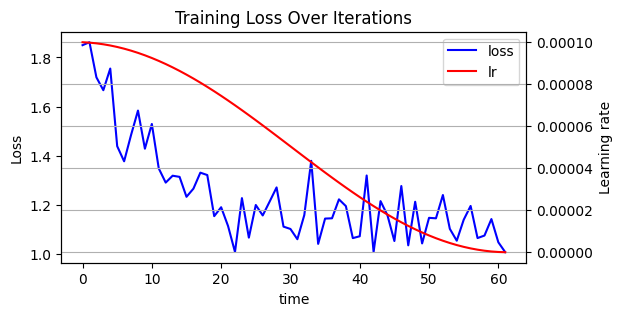

Run evaluation...


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

{'top_1_accuracy': 0.6582, 'top_5_accuracy': 0.8656}


In [ ]:
train_batch_size = 32
n_epochs = 1
train_lr = 1e-4

train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10
)

print(eval(model, test_loader))
# {'top_1_accuracy': 0.6563, 'top_5_accuracy': 0.8676} #lr=1e-4 bs=32 small dataset
# {'top_1_accuracy': 0.6738, 'top_5_accuracy': 0.8746} #lr=1e-4 bs=32 large dataset

In [10]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

path_to_save = os.path.join(model_save_path, 'resnet_4bit_ce.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

5.957 Mb


In [ ]:
# TEST
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT4_PER_TENSOR_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

print('Naive datafree:', eval(model, test_loader, verbose=False))

path_to_load = os.path.join(model_save_path, 'resnet_4bit_ce.pth')
print(f'Load state_dict {path_to_load}...')
print_file_size(path_to_load)
model.load_state_dict(torch.load(path_to_load, weights_only=True))

print('After finetuning:', eval(model, test_loader, verbose=False))

Naive datafree: {'top_1_accuracy': 0.0052, 'top_5_accuracy': 0.0148}
Load state_dict models/resnet_4bit_ce.pth...
5.957 Mb
Naive datafree: {'top_1_accuracy': 0.6582, 'top_5_accuracy': 0.8656}


##### per channel datafree

In [19]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT4_PER_CHANNEL_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.6162, 'top_5_accuracy': 0.8412}

path_to_save = os.path.join(model_save_path, 'resnet_4bit_per_channel_init.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

Run evaluation...


100%|██████████| 40/40 [00:27<00:00,  1.45it/s]

{'top_1_accuracy': 0.6148, 'top_5_accuracy': 0.8408}
6.004 Mb


##### per channel with CE finetuning

In [21]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT4_PER_CHANNEL_CONFIG).wrap_model(model)

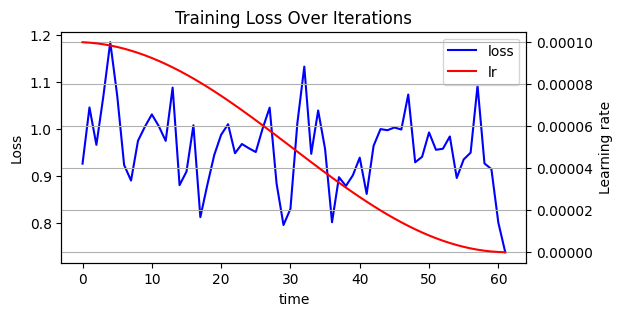

Run evaluation...


100%|██████████| 40/40 [00:26<00:00,  1.51it/s]

{'top_1_accuracy': 0.6842, 'top_5_accuracy': 0.8838}


In [ ]:
train_batch_size = 32
n_epochs = 1
train_lr = 1e-4

train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10
)


res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.6867, 'top_5_accuracy': 0.8842} #lr=1e-4 bs=32 small dataset
# {'top_1_accuracy': 0.6874, 'top_5_accuracy': 0.8849} #lr=1e-4 bs=32 large dataset

In [24]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)
path_to_save = os.path.join(model_save_path, 'resnet_4bit_per_channel_ce.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

6.004 Mb


### INT3

In [6]:
from resources.wrap_configs import (INT3_PER_CHANNEL_CONFIG, 
									INFERENCE_CONFIG)

##### data free

In [26]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.0012, 'top_5_accuracy': 0.0063}

Run evaluation...


100%|██████████| 40/40 [00:26<00:00,  1.50it/s]

{'top_1_accuracy': 0.0012, 'top_5_accuracy': 0.0058}


##### CE finetuning

In [29]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)

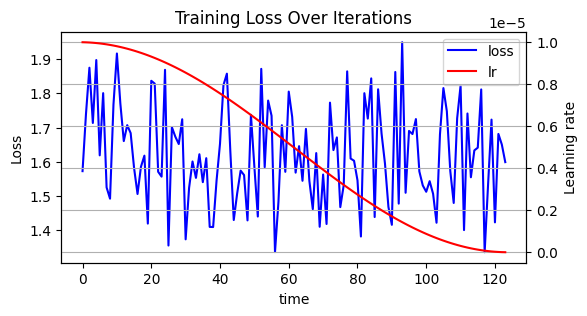

Run evaluation...


100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

{'top_1_accuracy': 0.6006, 'top_5_accuracy': 0.8326}


In [30]:
train_batch_size = 16
n_epochs = 1
train_lr = 1e-5

train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10
)

res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.6579, 'top_5_accuracy': 0.8660} lr=1e-4 bs=16 large dataset
# {'top_1_accuracy': 0.6613, 'top_5_accuracy': 0.8689} lr=1e-5 bs=16 large dataset


##### KD finetune

In [31]:
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)

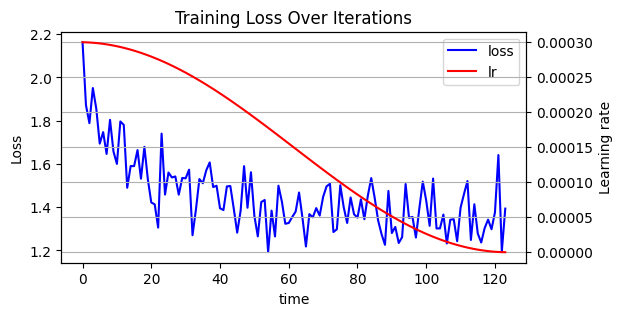

Run evaluation...


100%|██████████| 40/40 [00:27<00:00,  1.46it/s]

{'top_1_accuracy': 0.6558, 'top_5_accuracy': 0.8682}


In [32]:
train_batch_size = 16
n_epochs = 1
train_lr = 3e-4


teacher_model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
train_loader, optimizer = prepare_for_finetuning(
	model=model, 
	train_dataset=train_dataset, 
	train_batch_size=train_batch_size, 
	train_lr=train_lr
)

kd_finetune(
        model, 
        teacher_model,
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10,
        T=2,
        ce_loss_weight=0.75
)

res = eval(model, test_loader)
print(res)

# {'top_1_accuracy': 0.6668, 'top_5_accuracy': 0.8735} lr=2e-4 bs=16 large dataset
# {'top_1_accuracy': 0.6686, 'top_5_accuracy': 0.8714} lr=3e-4 bs=16 large dataset

In [33]:
Wrapper(**INFERENCE_CONFIG).wrap_model(model)
path_to_save = os.path.join(model_save_path, 'resnet_3bit_per_channel_kd.pth')
torch.save(model.state_dict(), path_to_save)
print_file_size(path_to_save)

4.674 Mb


In [ ]:
# TEST
model = AutoModelForImageClassification.from_pretrained(path_to_pretrained_resnet18).to(device)
Wrapper(**INT3_PER_CHANNEL_CONFIG).wrap_model(model)
Wrapper(**INFERENCE_CONFIG).wrap_model(model)

print('Naive datafree:', eval(model, test_loader, verbose=False))

path_to_load = os.path.join(model_save_path, 'resnet_3bit_per_channel_kd.pth')
print(f'Load state_dict {path_to_load}...')
print_file_size(path_to_load)
model.load_state_dict(torch.load(path_to_load, weights_only=True))

print('After finetuning:', eval(model, test_loader, verbose=False))


Naive datafree: {'top_1_accuracy': 0.0012, 'top_5_accuracy': 0.0058}
Load from models/resnet_3bit_per_channel_kd.pth...
After finetuning: {'top_1_accuracy': 0.6558, 'top_5_accuracy': 0.8682}


### PARETTO FRONT